<a href="https://colab.research.google.com/github/Abdelgafar-Gamal/Flight-Reservation-Database/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [ ]:
import pandas as pd # Data Manipulation
import numpy as np # Arrays and Math
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder # Scaling and Encoding
import matplotlib.pyplot as plt # Graphical Representation
import seaborn as sns # Graphical Representation
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif # Feature Selection
from sklearn.ensemble import RandomForestClassifier # for random forest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix as cm
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split

%matplotlib inline

**Extracting Data**

In [ ]:
train_data = pd.read_csv("train_dataset.csv")
test_data = pd.read_csv("test_dataset.csv")
df_train = train_data.copy() # A Copy which will be preproccessed
df_test = test_data.copy()

# **Preprocessing**

**Removing Duplicates**

In [ ]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

NameError: name 'df_train' is not defined

**Handling Missing Values**

In [ ]:
for df in [df_train, df_test]:
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:  # Fill numerical columns with mean
            df[col] = df[col].fillna(df[col].mean())
        else:  # Fill categorical columns with mode
            df[col] = df[col].fillna(df[col].mode()[0])

**Handle Outliers (IQR method for numeric columns)**

In [ ]:
for df in [df_train, df_test]:
    for col in df.select_dtypes(include=[np.number]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Clip the outliers to the boundary values
        df[col] = np.clip(df[col], lower_bound, upper_bound)

**Encode Categorical Variables**

In [ ]:
for df in [df_train, df_test]:
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

**Scaling and Normalization**

In [ ]:
scaler = MinMaxScaler()
numeric_cols = df_train.select_dtypes(include=[np.number]).columns
target_column = 'NObeyesdad'
if target_column in numeric_cols:
    numeric_cols = numeric_cols.drop(target_column)

# Fit the scaler on the train set and apply it to both train and test sets
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

**Comparing Original Data with the Preproccessed**

In [ ]:
train_data.info()
print(train_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1900 non-null   object 
 1   Age                             1900 non-null   int64  
 2   Height                          1900 non-null   float64
 3   Weight                          1900 non-null   float64
 4   family_history_with_overweight  1900 non-null   object 
 5   FAVC                            1900 non-null   object 
 6   FCVC                            1888 non-null   float64
 7   NCP                             1900 non-null   float64
 8   CAEC                            1900 non-null   object 
 9   SMOKE                           1900 non-null   object 
 10  CH2O                            1900 non-null   float64
 11  SCC                             1900 non-null   object 
 12  FAF                             19

In [ ]:
df_train.info()
print(df.isnull().sum())
# All the columns are float and there isn't any null values

<class 'pandas.core.frame.DataFrame'>
Index: 1878 entries, 0 to 1899
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1878 non-null   float64
 1   Age                             1878 non-null   float64
 2   Height                          1878 non-null   float64
 3   Weight                          1878 non-null   float64
 4   family_history_with_overweight  1878 non-null   float64
 5   FAVC                            1878 non-null   float64
 6   FCVC                            1878 non-null   float64
 7   NCP                             1878 non-null   float64
 8   CAEC                            1878 non-null   float64
 9   SMOKE                           1878 non-null   float64
 10  CH2O                            1878 non-null   float64
 11  SCC                             1878 non-null   float64
 12  FAF                             1878 no

# **Feature Extraction & Selection**

/tmp/ipykernel_7144/2040822453.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["BMI"].fillna(df_train["BMI"].mean(), inplace=True)
/tmp/ipykernel_7144/2040822453.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

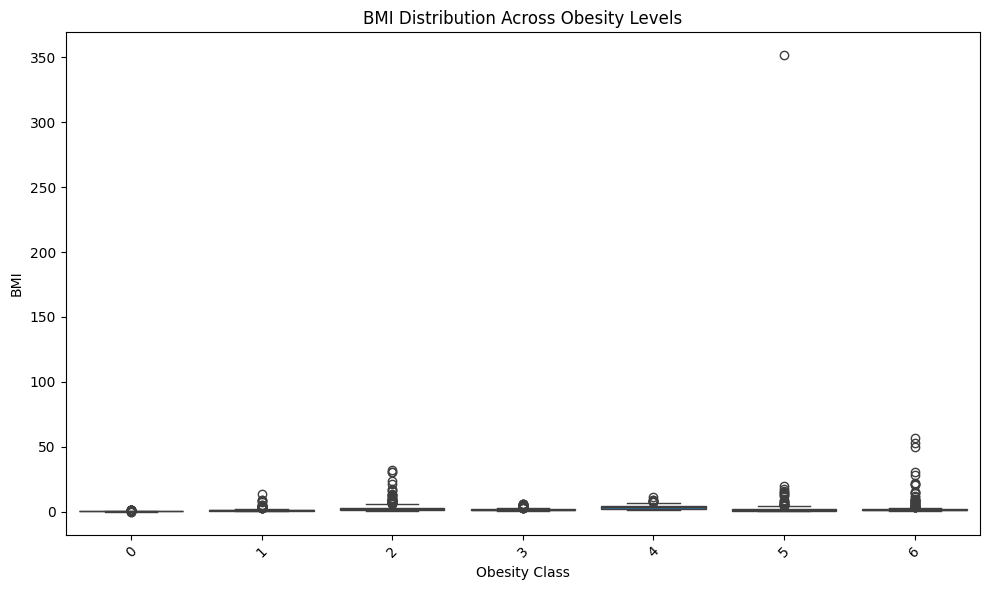

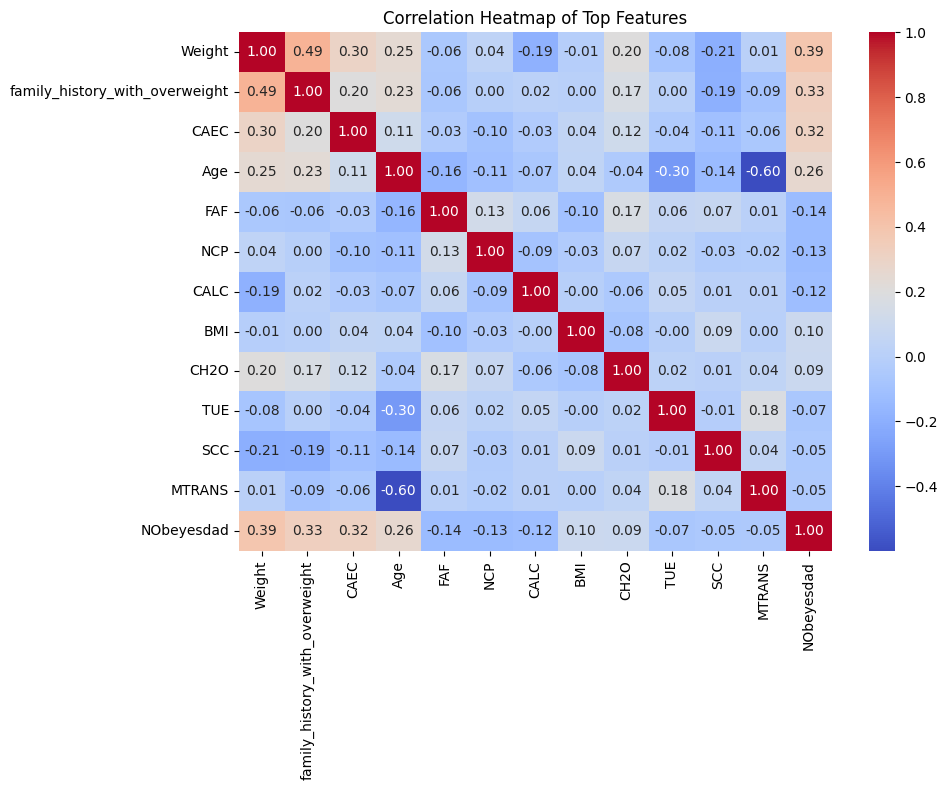

Common top features: ['CAEC', 'family_history_with_overweight', 'CALC', 'SCC', 'Gender', 'BMI', 'FCVC', 'TUE', 'MTRANS', 'FAF', 'CH2O', 'Age', 'NCP', 'Height', 'Weight']


In [ ]:
# ----- SETUP -----
target_column = 'NObeyesdad'

# Add BMI to both train and test data
df_train["BMI"] = df_train["Weight"] / (df_train["Height"] ** 2)
df_test["BMI"] = df_test["Weight"] / (df_test["Height"] ** 2)

# Replace infinity values with NaN and fill NaNs with the mean
df_train["BMI"] = df_train["BMI"].replace([np.inf, -np.inf], np.nan)
df_test["BMI"] = df_test["BMI"].replace([np.inf, -np.inf], np.nan)
df_train["BMI"].fillna(df_train["BMI"].mean(), inplace=True)
df_test["BMI"].fillna(df_test["BMI"].mean(), inplace=True)

# Combine temporarily to select features from full distribution
df_full = pd.concat([df_train, df_test], axis=0)
X_full = df_full.drop(columns=[target_column])
y_full = df_full[target_column]

# Correlation
corr_matrix = df_full.corr()
correlated = corr_matrix[target_column].abs().sort_values(ascending=False)
top_corr = correlated.drop(index=target_column).head(12).index.tolist()

# Mutual Info
mi_selector = SelectKBest(score_func=mutual_info_classif, k=12)
mi_selector.fit(X_full, y_full)
top_mi = pd.Series(mi_selector.scores_, index=X_full.columns).sort_values(ascending=False).head(12).index.tolist()

# Random Forest
rf = RandomForestClassifier(random_state=0)
rf.fit(X_full, y_full)
top_rf = pd.Series(rf.feature_importances_, index=X_full.columns).sort_values(ascending=False).head(12).index.tolist()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_full[target_column], y=df_full["BMI"])
plt.title("BMI Distribution Across Obesity Levels")
plt.xticks(rotation=45)
plt.ylabel("BMI")
plt.xlabel("Obesity Class")
plt.tight_layout()
plt.show()

# Heat Map
top_features = top_corr + [target_column]
plt.figure(figsize=(10, 8))
sns.heatmap(df_full[top_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Top Features")
plt.tight_layout()
plt.show()

# Common features
common_features = list(set(top_corr) | set(top_mi) | set(top_rf))
# common_features = list(set(top_corr) & set(top_mi) & set(top_rf))
print("Common top features:", common_features)

# Split the data into train and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train[common_features])
X_test_scaled = scaler.transform(df_test[common_features])

y_train = df_train[target_column]
y_test = df_test[target_column]

# **Models**

**Logistic Regression**

Epoch 0, Loss: 5.3738
Epoch 100, Loss: 0.7095
Epoch 200, Loss: 0.6096
Epoch 300, Loss: 0.5537
Epoch 400, Loss: 0.5154
Epoch 500, Loss: 0.4864
Epoch 600, Loss: 0.4632
Epoch 700, Loss: 0.4440
Epoch 800, Loss: 0.4277
Epoch 900, Loss: 0.4135


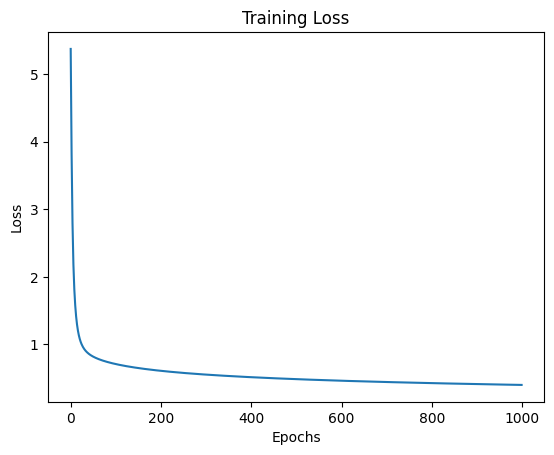

In [ ]:
# One-hot encode target
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(df_train[[target_column]])
y_test_encoded = encoder.transform(df_test[[target_column]])

# Feature and label matrices
X_train = X_train_scaled
X_test = X_test_scaled
Y_train = y_train_encoded
Y_test = y_test_encoded

n_samples, n_features = X_train.shape
n_classes = Y_train.shape[1]

# Initialize weights
np.random.seed(42)
weights = np.random.randn(n_features, n_classes)
bias = np.zeros((1, n_classes))

# Softmax function
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Training loop
learning_rate = 1
epochs = 1000
losses = []

for epoch in range(epochs):
    # Forward
    logits = np.dot(X_train, weights) + bias
    y_pred = softmax(logits)

    # Cross-entropy loss
    loss = -np.mean(np.sum(Y_train * np.log(y_pred + 1e-15), axis=1))
    losses.append(loss)

    # Backward
    error = y_pred - Y_train
    dW = np.dot(X_train.T, error) / n_samples
    dB = np.sum(error, axis=0, keepdims=True) / n_samples

    # Update
    weights -= learning_rate * dW
    bias -= learning_rate * dB

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Plot loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

**Evaluation**


Train Accuracy: 0.8833865814696485
Test Accuracy: 0.8483412322274881

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        24
           1       0.95      0.66      0.78        32
           2       0.86      0.83      0.84        29
           3       0.93      1.00      0.96        38
           4       0.93      1.00      0.97        28
           5       0.62      1.00      0.76        26
           6       0.95      0.53      0.68        34

    accuracy                           0.85       211
   macro avg       0.87      0.86      0.84       211
weighted avg       0.88      0.85      0.84       211



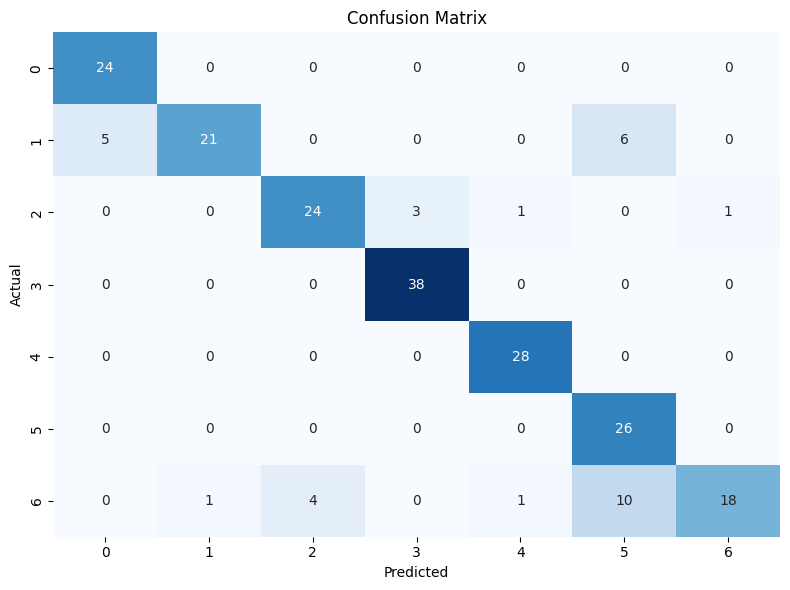

In [ ]:
# Predict
train_pred = np.argmax(softmax(np.dot(X_train, weights) + bias), axis=1)
test_pred = np.argmax(softmax(np.dot(X_test, weights) + bias), axis=1)

# Decode labels
y_train_true = np.argmax(Y_train, axis=1)
y_test_true = np.argmax(Y_test, axis=1)

# Metrics
print("\nTrain Accuracy:", accuracy_score(y_train_true, train_pred))
print("Test Accuracy:", accuracy_score(y_test_true, test_pred))
print("\nClassification Report:\n", classification_report(y_test_true, test_pred))

# --- Confusion Matrix ---
cm_matrix = cm(y_test_true, test_pred)  # Using alias 'cm'
plt.figure(figsize=(8, 6))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

**KNN**

Train Accuracy: 0.8189563365282215
Test Accuracy: 0.7962085308056872

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        24
           1       0.86      0.59      0.70        32
           2       0.71      0.69      0.70        29
           3       0.84      1.00      0.92        38
           4       0.85      1.00      0.92        28
           5       0.67      0.92      0.77        26
           6       0.83      0.44      0.58        34

    accuracy                           0.80       211
   macro avg       0.80      0.81      0.79       211
weighted avg       0.80      0.80      0.78       211



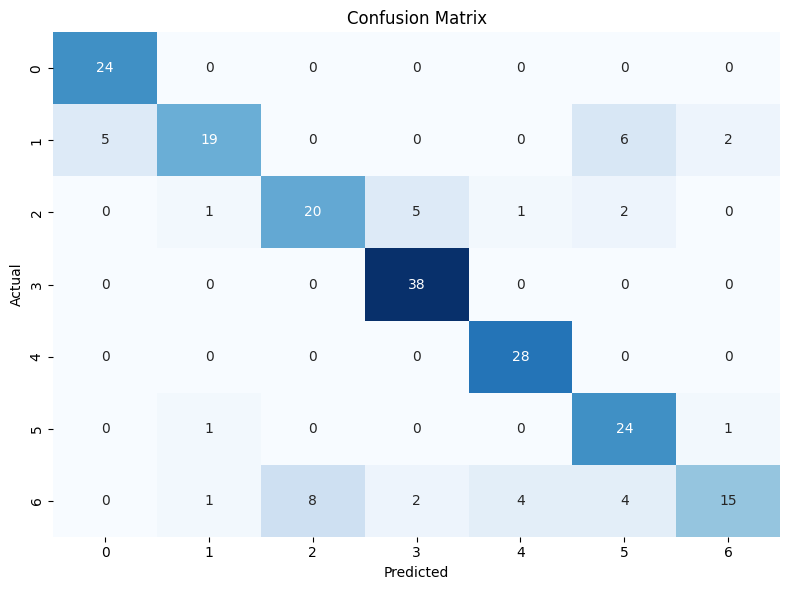

In [ ]:
# Reuse common_features list you obtained from feature selection
# (Make sure it exists in the environment)
x_train = df_train[common_features]
y_train = df_train[target_column]

x_test = df_test[common_features]
y_test = df_test[target_column]

# ----- 3. Train KNN -----
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

# ----- 4. Evaluation -----
train_accuracy = knn.score(x_train, y_train)
test_accuracy = knn.score(x_test, y_test)
y_pred = knn.predict(x_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm_matrix = cm(y_test, y_pred)  # Using alias 'cm'
plt.figure(figsize=(8, 6))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

**Decision Tree**

Test Accuracy: 84.36%
Train Accuracy: 87.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.86      0.56      0.68        32
           2       0.74      0.86      0.79        29
           3       1.00      0.79      0.88        38
           4       1.00      1.00      1.00        28
           5       0.64      0.96      0.77        26
           6       0.86      0.88      0.87        34

    accuracy                           0.84       211
   macro avg       0.86      0.85      0.84       211
weighted avg       0.87      0.84      0.84       211



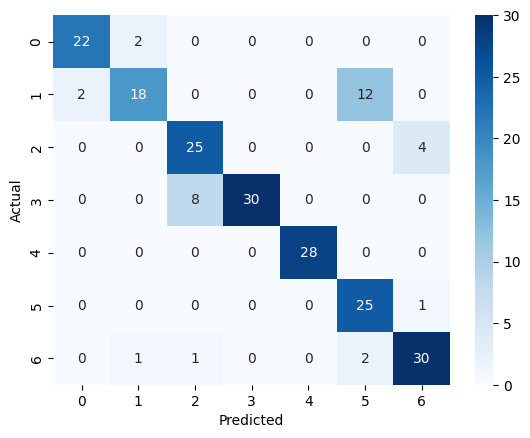

In [ ]:
#-2-Building the model and training it

model = DecisionTreeClassifier(criterion='entropy', max_depth =5, random_state=42)
model.fit(x_train, y_train)

#-3-predicting the values

y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)

#-4-Calculating accuracy

accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)

#-5-Printing Model Predictions

print(f"Train Accuracy: {accuracy_train * 100:.2f}%")
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred_test))
cm_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm_matrix, annot=True, cmap="Blues", fmt='d')
plt.show()


**SVM**

Train Accuracy: 94.99%
Test Accuracy: 85.31%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.74      0.91      0.82        32
           2       0.71      0.76      0.73        29
           3       1.00      0.92      0.96        38
           4       1.00      1.00      1.00        28
           5       0.82      0.88      0.85        26
           6       0.77      0.59      0.67        34

    accuracy                           0.85       211
   macro avg       0.86      0.86      0.86       211
weighted avg       0.86      0.85      0.85       211



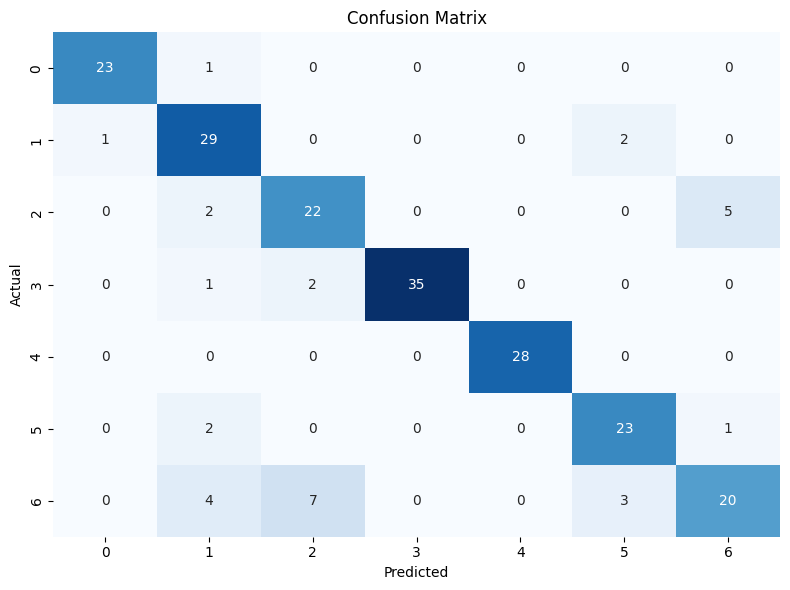

In [ ]:
model = SVC()
model.fit(X_train_scaled, y_train)

# Predictions
train_predictions = model.predict(X_train_scaled)
test_predictions = model.predict(X_test_scaled)

# Accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, test_predictions))

# --- Confusion Matrix ---
cm_matrix = cm(y_test, test_predictions)  # Using alias 'cm'
plt.figure(figsize=(8, 6))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

**XGBosst**

/home/ahmad/Downloads/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:52:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 100.00%
Test Accuracy: 96.68%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        32
           2       0.97      1.00      0.98        29
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        28
           5       0.81      1.00      0.90        26
           6       1.00      0.79      0.89        34

    accuracy                           0.97       211
   macro avg       0.97      0.97      0.97       211
weighted avg       0.97      0.97      0.97       211



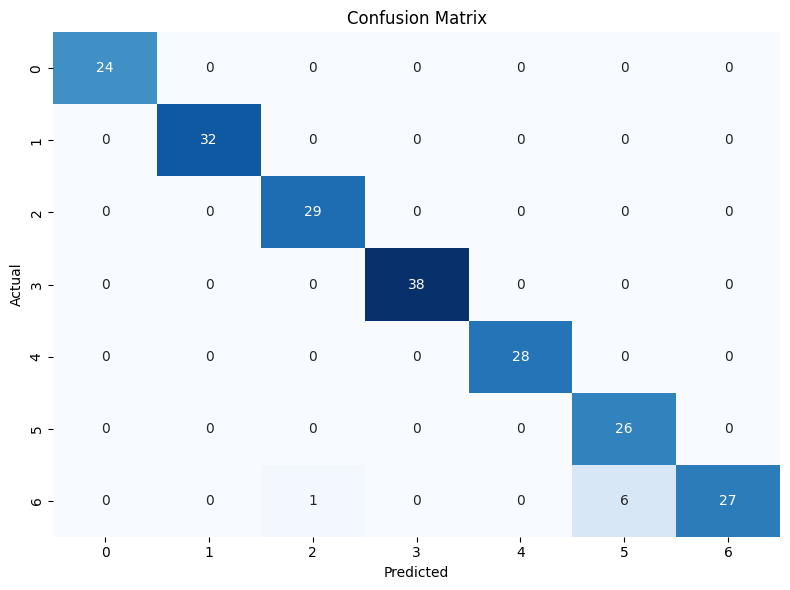

In [ ]:
# Train the model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# Predict
train_preds = model.predict(X_train_scaled)
test_preds = model.predict(X_test_scaled)

# Accuracy
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, test_preds))

# --- Confusion Matrix ---
cm_matrix = cm(y_test, test_preds)  # Using alias 'cm'
plt.figure(figsize=(8, 6))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

**Random Forest**

Train Accuracy: 98.72%
Test Accuracy: 97.16%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.86      1.00      0.93        32
           2       1.00      0.97      0.98        29
           3       0.97      1.00      0.99        38
           4       1.00      1.00      1.00        28
           5       1.00      0.92      0.96        26
           6       1.00      0.91      0.95        34

    accuracy                           0.97       211
   macro avg       0.98      0.97      0.97       211
weighted avg       0.97      0.97      0.97       211



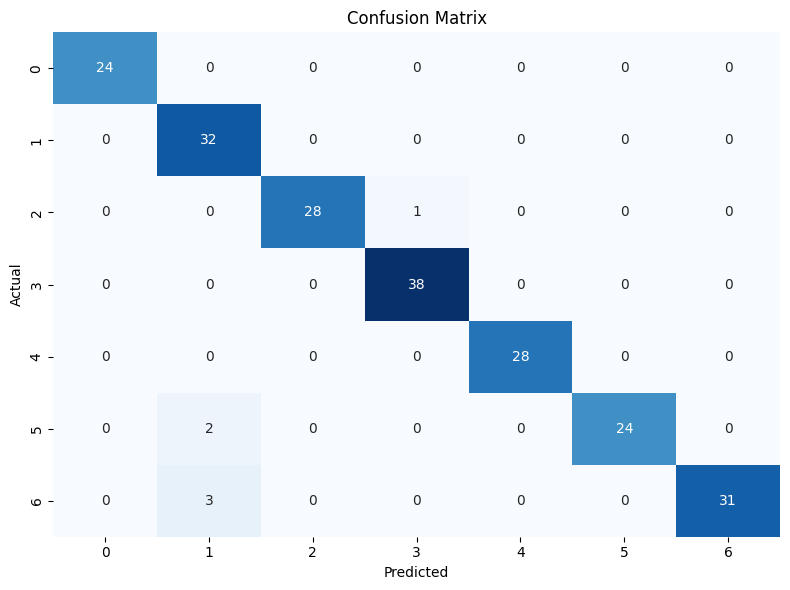

In [ ]:
# --- Train Random Forest ---
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=5,
    max_features='log2',
    random_state=42,
    bootstrap=True
)
rf_classifier.fit(X_train_scaled, y_train)

# --- Predictions on real test set ---
y_pred = rf_classifier.predict(X_test_scaled)

# --- Accuracy scores ---
test_acc = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y_train, rf_classifier.predict(X_train_scaled))

# --- Print results ---
print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm_matrix = cm(y_test, y_pred)  # Using alias 'cm'
plt.figure(figsize=(8, 6))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()